# Reproduce the result figures for Sec. 6, experiments using the ethereum data

In [70]:
import pandas as pd
import torch
import os
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import pearsonr, spearmanr, kendalltau
import tikzplotlib
import seaborn as sns

import src.evaluation as evaluation
import src.utils
import src.dataprocessing as dataproc
import  src.testutils as testutils
# import src.evaluationutils as evalutils


In [3]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
def plot_mag_error_curves(gt_flow, add_mm_marker=False, xlim=(-1, 1), **flows):
    fig, ax = plt.subplots()
    
    auc = {}

    thres = np.logspace(xlim[0], xlim[1], 100)
    for (name, flow), color_ in zip(flows.items(), default_colors):
        rel_error = np.maximum(np.abs(flow - gt_flow), 1e-6) / np.maximum(np.abs(gt_flow), 1e-6)
        median_rel_error = np.median(rel_error)

        lower_than_p = []
        for t in thres:
            p = (rel_error < t).sum() / len(rel_error)
            lower_than_p.append(p)

        auc[name] = np.trapz(y=lower_than_p, x=thres)
        if name == 'zeros':
            ax.plot(thres, 100 * np.asarray(lower_than_p), '--', color='k', label=name, alpha=0.76)
        else:
            ax.plot(thres, 100 * np.asarray(lower_than_p), label=name, color=color_)
            if add_mm_marker:
                ax.plot([median_rel_error, median_rel_error], [-5, 50], '--', color=color_, alpha=0.4)

    ax.legend(fontsize=14)
    ax.set_xscale('log')
    ax.set_xlabel('t')
    ax.set_ylabel('% rel. error $<$ t')
    if add_mm_marker:
        ax.plot([10**xlim[0], 10**xlim[1]], [50, 50], '--', color='k', alpha=0.4)
        
    ax.axis([10**xlim[0], 10**xlim[1], -5, 105])

    return fig, ax, auc

In [40]:
def flow_transform(flow, scaling=1.):
    flow_log = np.sign(flow) * np.log10(1 + scaling * np.abs(flow))
    flow_log_inv = np.sign(flow) * np.log10(1 + 1. / np.maximum(np.abs(flow), 1e-6))
    return flow_log, flow_log_inv

In [28]:
folder = "results/ethereum/"
save_folder = 'figures/ethereum/'
tbl_save_folder = 'tables/ethereum/'
os.makedirs(save_folder, exist_ok=True)
os.makedirs(tbl_save_folder, exist_ok=True)
test_cache_folder = 'results/ethereum/test_cache'

disp_names = {
    'joint': 'gated',
    'gated': 'gated',
    'grad': 'grad',
    'dnn2_engi_feat': 'f.e.+dnn2',
    'dnn2_node2vec': 'n2v+dnn2',
    'fairness_goodness': 'Kumar et.al.',
    'zeros': 'zeros',
    'init': 'grad (MSE)'
}


## Print selected hyperparameters

In [74]:
results = dict()

results["gated"] = pd.read_csv(folder + "ethereum_joint_results.csv")
results["grad"] = pd.read_csv(folder + "ethereum_grad_baseline_results.csv")
results.update(testutils.split_baselines(pd.read_csv(folder + "ethereum_baseline_results.csv")))
# results["init"] = pd.read_csv(folder + "ethereum_init_results.csv")

best_hyperparameters, _ = testutils.get_all_best_hp(results, eval_col=["val_MeAE*", "val_MeAE"])
for key, val in best_hyperparameters.items():
    print(key, ":", val)

# Results table

In [9]:
test_results = pd.read_csv(os.path.join(test_cache_folder, "results_table.csv"), index_col=0)


In [31]:
test_MeAE_res = test_results.loc[:, ["test_MeAE"]].T.rename(columns=disp_names, index={"test_MeAE": "medain abs. error"})
test_MeAE_res.to_latex(os.path.join(tbl_save_folder, f"ethereum_test_MeAE.tex"), 
                                        escape=False, float_format="%.2f", index=False)
display(test_MeAE_res)

,gated,grad,f.e.+dnn2,n2v+dnn2,Kumar et.al.,zeros,grad (MSE)
medain abs. error,9.342333,10.387247,13.102469,11.247078,14.18594,14.612103,396.63205


# Plot the cumulative relative errors

In [ ]:
flows = torch.load(os.path.join(test_cache_folder, "flows.pth"))
gt_flow = flows["gt_flow"]
flows = {disp_names[key]: flow for key, flow in flows.items() if key in disp_names}

<IPython.core.display.Javascript object>


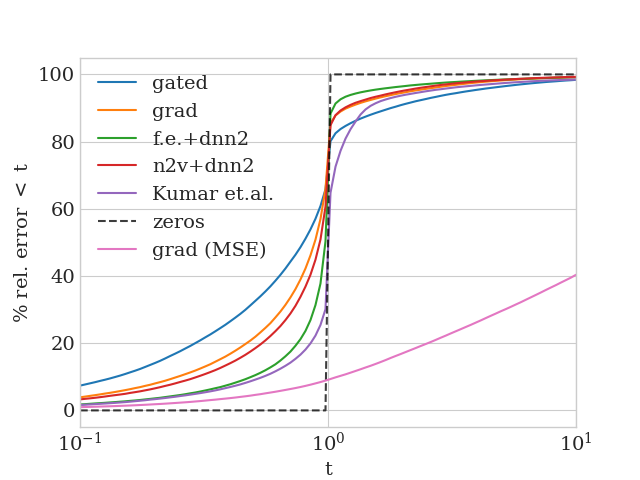

{'gated': 8.907455976678335, 'grad': 9.013445009507247, 'f.e.+dnn2': 8.962584863493875, 'n2v+dnn2': 9.003655807316784, 'Kumar et.al.': 8.766672419183134, 'zeros': 8.999729510400874, 'grad (MSE)': 2.6721289194085283}


In [39]:
plot_name = "rel_error_joint"
fig, ax, auc = plot_mag_error_curves(gt_flow, False, **flows)
fig.savefig(os.path.join(save_folder, plot_name + ".pdf"), bbox_inches='tight')
tikzplotlib.save(os.path.join(save_folder, plot_name + ".tex"))
print(auc)

In [42]:
trans_flows = {}
trans_inv_flows = {}
const = 1.
for name, flow in flows.items():
    trans_flows[name], trans_inv_flows[name] = flow_transform(const * flow)

log_gt_flow, log_gt_flow_inv = flow_transform(const * gt_flow)

# Correlation statistics 

In [50]:
for flow_key in flows.keys():
    print(flow_key, ":", spearmanr(gt_flow, flows[flow_key]), pearsonr(gt_flow, flows[flow_key]))

for key, flow_ in trans_flows.items():
    print(key, pearsonr(log_gt_flow, flow_)[0]**2)

gated : SpearmanrResult(correlation=0.6741152323719434, pvalue=0.0) (0.023235392371772558, 2.716584631911106e-21)
grad : SpearmanrResult(correlation=0.6285174376325676, pvalue=0.0) (-0.011146249585437668, 5.52311315394831e-06)
f.e.+dnn2 : SpearmanrResult(correlation=0.5336577515382324, pvalue=0.0) (-0.0026967292962556924, 0.27163125916565123)
n2v+dnn2 : SpearmanrResult(correlation=0.6014788358388267, pvalue=0.0) (0.0004898143973753738, 0.8417378681287104)
Kumar et.al. : SpearmanrResult(correlation=0.002417247480703746, pvalue=0.3244357737501711) (0.00038904179859620345, 0.8739907631452806)
zeros : SpearmanrResult(correlation=nan, pvalue=nan) (nan, nan)
grad (MSE) : SpearmanrResult(correlation=0.028949738366353815, pvalue=3.733980117037907e-32) (-0.012262361296023266, 5.766007376072559e-07)
gated 0.3782779601768166
grad 0.32328172727535254
f.e.+dnn2 0.2410112888928095
n2v+dnn2 0.31455697989010695
Kumar et.al. 0.0007849132191552036
zeros nan
grad (MSE) 0.0012003523429213493


/home/ciwan/python_envs/ggf/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/ciwan/python_envs/ggf/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<IPython.core.display.Javascript object>


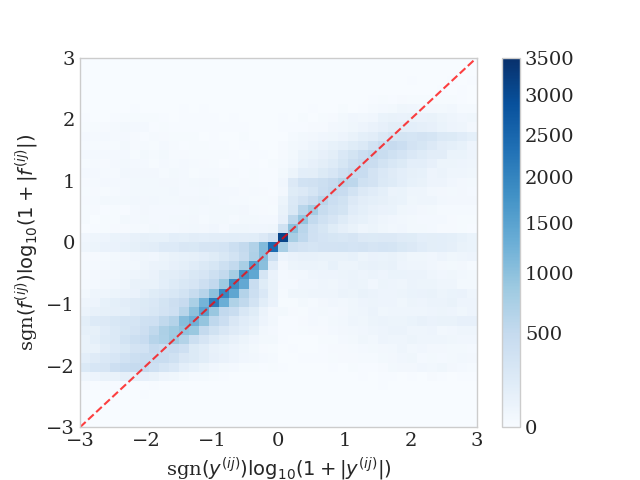

<IPython.core.display.Javascript object>


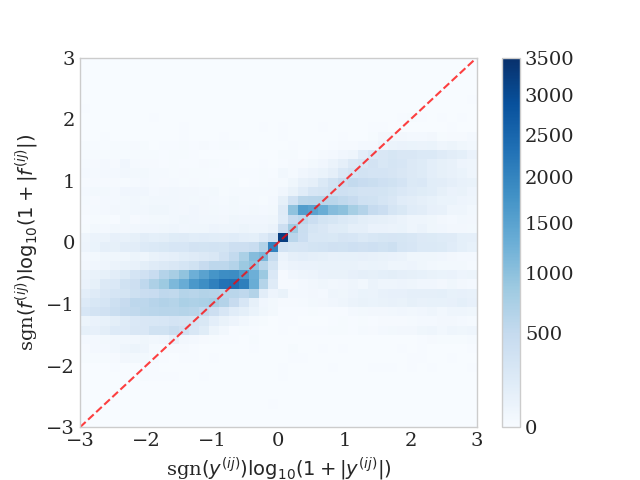

<IPython.core.display.Javascript object>


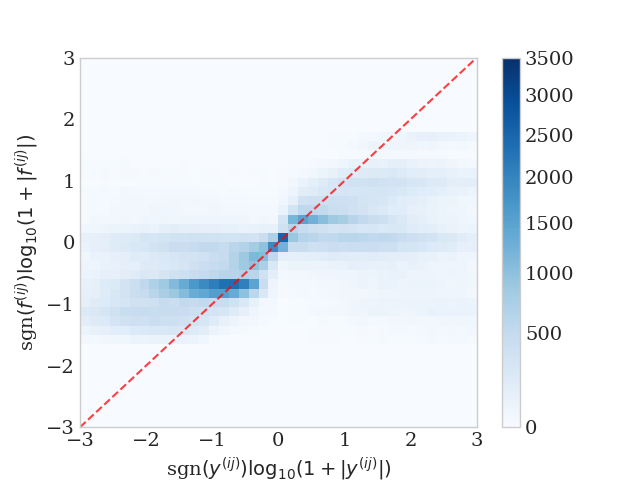

In [49]:
flow_key = 'gated'
for flow_key in ["gated", "grad", "n2v+dnn2"]:
    plot_name = "flow_correlation" + "_" + flow_key
    fig, ax = plt.subplots()
    h = ax.hist2d(log_gt_flow, trans_flows[flow_key], bins=40, 
                  range=[[-3, 3], [-3, 3]],
                  norm=mcolors.PowerNorm(0.7, vmax=3500),
                  cmap=plt.cm.Blues)
    fig.colorbar(h[3], ax=ax)
    ax.set_xlabel(r"sgn$(y^{(ij)})\log_{10}(1 + |y^{(ij)}|)$")
    ax.set_ylabel(r"sgn$(f^{(ij)})\log_{10}(1 + |f^{(ij)}|)$")
    ax.plot(ax.get_xlim(), ax.get_ylim(), '--', color='r', alpha=0.75)
    fig.savefig(os.path.join(save_folder, plot_name + ".pdf"), bbox_inches='tight')
    tikzplotlib.save(os.path.join(save_folder, plot_name + ".tex"))


# Histograms

In [51]:
hist_abs_data = pd.DataFrame(
{'gt': np.maximum(np.abs(gt_flow), 1e-6),
 'gated': np.maximum(np.abs(flows['gated']), 1e-6),
#   'dnn2': np.maximum(np.abs(flows['dnn2']), 1e-6),
 'grad': np.maximum(np.abs(flows['grad']), 1e-6),
 disp_names["init"]:  np.maximum(np.abs(flows[disp_names["init"]]), 1e-6)
}).melt(var_name='model', value_name="amount")

<IPython.core.display.Javascript object>


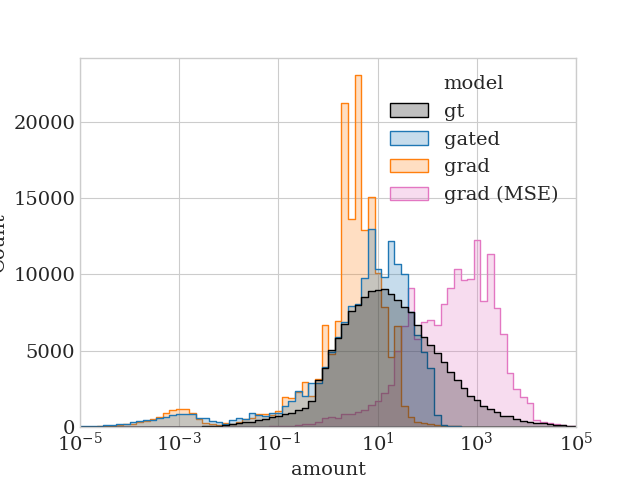

In [52]:
plot_name = "flow_abs_hist"
fig, ax = plt.subplots()
g = sns.histplot(hist_abs_data, x="amount", hue="model",  
                  bins=100, common_bins=True,
                 kde=False, element="step", log_scale=True,
                palette={'gt': 'k', 'gated': default_colors[0], 'grad': default_colors[1],
                        disp_names["init"]: default_colors[6]})
ax.set_xlim((1e-5, 1e5))
fig.savefig(os.path.join(save_folder, plot_name + ".pdf"), bbox_inches='tight')
tikzplotlib.save(os.path.join(save_folder, plot_name + ".tex"))
# g.despine(left=True)
# plt.legend(loc='upper right')

## Visualise representations

In [60]:
representations = torch.load(os.path.join(test_cache_folder, "representations.pth"))
graph = dataproc.Graph.read_csv("data/preprocessed_ethereum_2018_2020.csv")
node2name = pd.read_csv("data/ethereum_node2name.csv", index_col=0)

In [144]:
emb_threshold = 0.0
degree_threshold = 0

too_small_emb = np.abs(representations["gated"]['emb']) < emb_threshold
too_small_gates =  np.abs(representations["gated"]['gates']) < emb_threshold
z = representations["gated"]['emb'][~(too_small_emb | too_small_gates)]
z_large, z_small = flow_transform(z)
u = representations["gated"]['gates'][~(too_small_emb | too_small_gates)]

emb_data = pd.DataFrame(
    {'emb': z_large,
    'u': u,
    'degree': graph.degrees}
)

emb_data = emb_data.loc[emb_data["degree"] > degree_threshold, :].sort_values("degree", ascending=True)

<IPython.core.display.Javascript object>


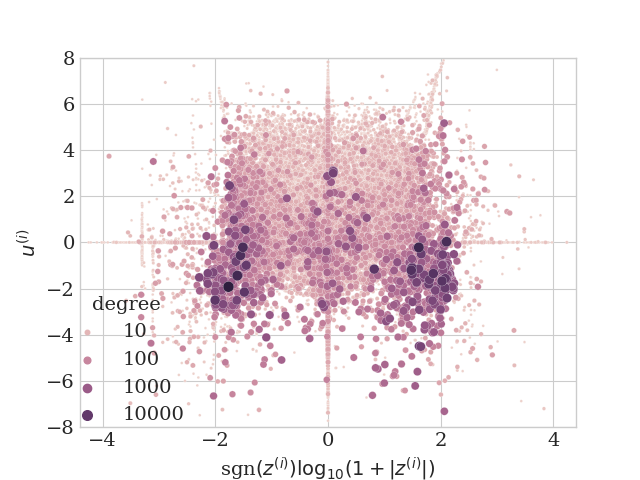

In [145]:
plot_name = "degree_coloured_representations"
fig, ax = plt.subplots()
sns.scatterplot(data=emb_data, x="emb", y="u",
                hue="degree", hue_norm=mcolors.LogNorm(vmin=3),
                size="degree", size_norm=mcolors.LogNorm(vmin=3), 
                sizes=(4, 60),
                legend="auto", rasterized=True)
ax.set_xlabel(r"sgn$(z^{(i)})\log_{10}(1 + |z^{(i)}|)$")
ax.set_ylabel(r"$u^{(i)}$")
# ax.legend(bbox_to_anchor=(1, 1), loc='upper left', title='degree')
# ax.legend(loc='lower left', title='degree')
ax.axis([-4.4, 4.4, -8, 8])
ax.legend(bbox_to_anchor=(-0.06, -0.04), loc='lower left', title='degree')
fig.savefig(os.path.join(save_folder, plot_name + ".pdf"), bbox_inches='tight', dpi=400)

In [146]:
high_deg_nodes = emb_data.tail(10).copy()
high_deg_nodes.loc[high_deg_nodes.index, "name"] = node2name.loc[high_deg_nodes.index, :].values
display(high_deg_nodes)

,emb,u,degree,name
57,1.490397,-1.108654,12767.0,0xf5bec430576ff1b82e44ddb5a1c93f6f9d0884f3
41,2.022465,-1.674439,14559.0,0x0d0707963952f2fba59dd06f2b425ace40b492fe
6,1.868195,-1.347492,16204.0,0x60d0cc2ae15859f69bf74dadb8ae3bd58434976b
60,1.477145,-1.204795,18483.0,0xd7b9a9b2f665849c4071ad5af77d8c76aa30fb32
449096,-1.552866,-0.563187,22230.0,0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c
452492,-1.509130,-0.213466,24819.0,0x829bd824b016326a401d083b33d092293333a830
1,2.103981,0.029744,26820.0,0x7a250d5630b4cf539739df2c5dacb4c659f2488d
446127,-1.608974,-1.437878,35821.0,0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5
19,1.611248,-0.217916,36653.0,0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be
174466,-1.765696,-1.920144,84318.0,0xea674fdde714fd979de3edf0f56aa9716b898ec8


In [153]:
node_type_lookup = {
    "0xea674fdde714fd979de3edf0f56aa9716b898ec8": "miner",
    "0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be": "exchange",
    "0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5": "miner",
    "0x7a250d5630b4cf539739df2c5dacb4c659f2488d": "token",
    "0x829bd824b016326a401d083b33d092293333a830": "miner",
    "0xd7b9a9b2f665849c4071ad5af77d8c76aa30fb32": "token",
    "0x60d0cc2ae15859f69bf74dadb8ae3bd58434976b": "exchange",
    "0x0d0707963952f2fba59dd06f2b425ace40b492fe": "exchange",
    "0xf5bec430576ff1b82e44ddb5a1c93f6f9d0884f3": "exchange",
    "0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c": "miner"
}
node_name_lookup = {
    "0xea674fdde714fd979de3edf0f56aa9716b898ec8": "Ethermine",
    "0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be": "Binance",
    "0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5": "Nanopool",
    "0x7a250d5630b4cf539739df2c5dacb4c659f2488d": "Uniswap",
    "0x829bd824b016326a401d083b33d092293333a830": "F2pool",
    "0xd7b9a9b2f665849c4071ad5af77d8c76aa30fb32": "Exmo",
    "0x60d0cc2ae15859f69bf74dadb8ae3bd58434976b": "ZB.com",
    "0x0d0707963952f2fba59dd06f2b425ace40b492fe": "gate.io",
    "0xf5bec430576ff1b82e44ddb5a1c93f6f9d0884f3": "yobit.net",
    "0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c": "Sparkpool"
}

node_textplace_lookup = {
    "0xea674fdde714fd979de3edf0f56aa9716b898ec8": (-4,0),
    "0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be": (3,3),
    "0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5": (-4,1),
    "0x7a250d5630b4cf539739df2c5dacb4c659f2488d": (3,2),
    "0x829bd824b016326a401d083b33d092293333a830": (-3.5, 4),
    "0xd7b9a9b2f665849c4071ad5af77d8c76aa30fb32": (3,-0.5),
    "0x60d0cc2ae15859f69bf74dadb8ae3bd58434976b": (3,-1.5),
    "0x0d0707963952f2fba59dd06f2b425ace40b492fe": (3,-3),
    "0xf5bec430576ff1b82e44ddb5a1c93f6f9d0884f3": (3,0.5),
    "0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c": (-4,2)
}
type_colour = dict(zip(["miner", "exchange", "token"], default_colors))
type_colour["token"] = type_colour["exchange"]

<IPython.core.display.Javascript object>


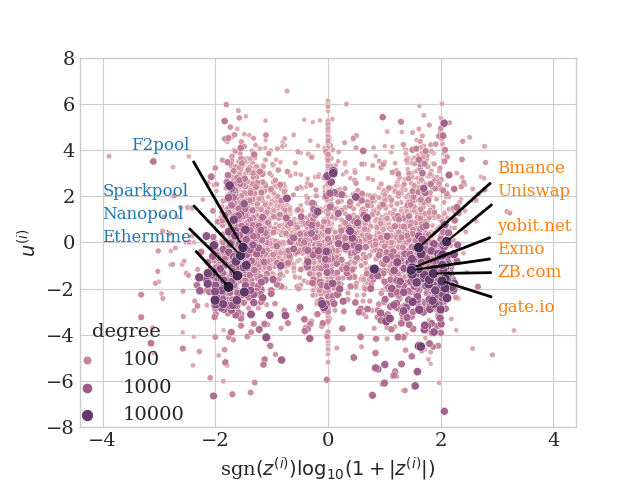

In [154]:
plot_name = "degree_coloured_representations"
fig, ax = plt.subplots()
sns.scatterplot(data=emb_data.loc[emb_data['degree'] > 15, :], x="emb", y="u",
                hue="degree", hue_norm=mcolors.LogNorm(vmin=3),
                size="degree", size_norm=mcolors.LogNorm(vmin=3), 
                sizes=(4, 60),
                legend="auto", rasterized=True)
ax.set_xlabel(r"sgn$(z^{(i)})\log_{10}(1 + |z^{(i)}|)$")
ax.set_ylabel(r"$u^{(i)}$")
# ax.legend(bbox_to_anchor=(1, 1), loc='upper left', title='degree')
# ax.legend(loc='lower left', title='degree')
ax.axis([-4.4, 4.4, -8, 8])
ax.legend(bbox_to_anchor=(-0.06, -0.04), loc='lower left', title='degree')

# sns.scatterplot(data=emb_data.loc[high_degs_df[1], :], x="emb", y="u",
#                 hue="degree", hue_norm=mcolors.LogNorm(vmin=3),
#                 size="degree", size_norm=mcolors.LogNorm(vmin=3), 
#                 sizes=(4, 60),
#                 legend="auto", rasterized=True)

for indx, name_hash in high_deg_nodes["name"].items():
    if name_hash not in node_type_lookup:
        print(name_hash, "not in lookup")
        continue

    node_name = node_name_lookup[name_hash]
#     node_name = node_type_lookup[hash_str]
    node_type = node_type_lookup[name_hash]
    node_coords = (emb_data.loc[indx, "emb"], emb_data.loc[indx, "u"])

    colour = type_colour[node_type]
    xytext = node_textplace_lookup[name_hash]
    ax.annotate(text=node_name, xy=node_coords, xytext=xytext, 
                arrowprops=dict(facecolor=colour, width=1, headwidth=1, shrink=0.05),
               color=colour, textcoords='data', fontsize=12)
fig.savefig(os.path.join(save_folder, plot_name + "_anotated_name.pdf"), bbox_inches='tight', dpi=400)

In [155]:
print(len(emb_data.loc[emb_data['degree'] > 15, :]))

4635
